In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.impute import KNNImputer, SimpleImputer
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv("/content/diabetes.csv")

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


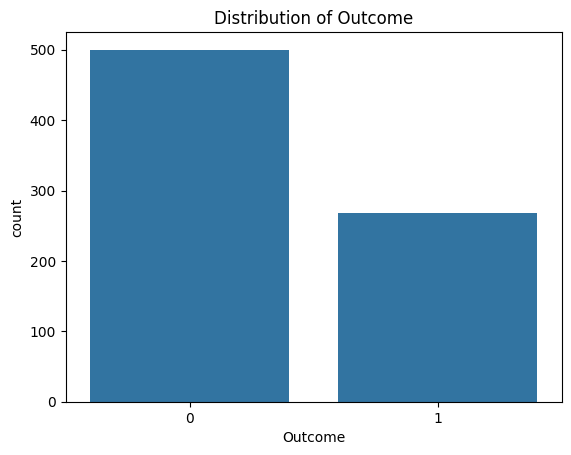

In [ ]:
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome')
plt.show()

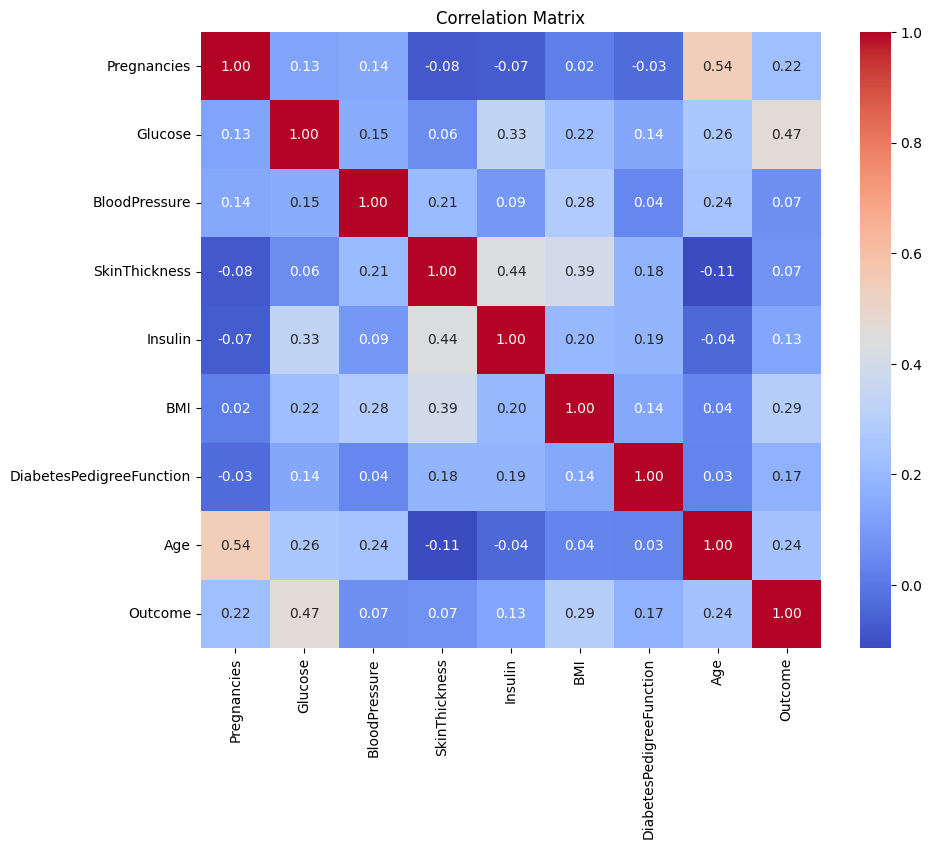

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

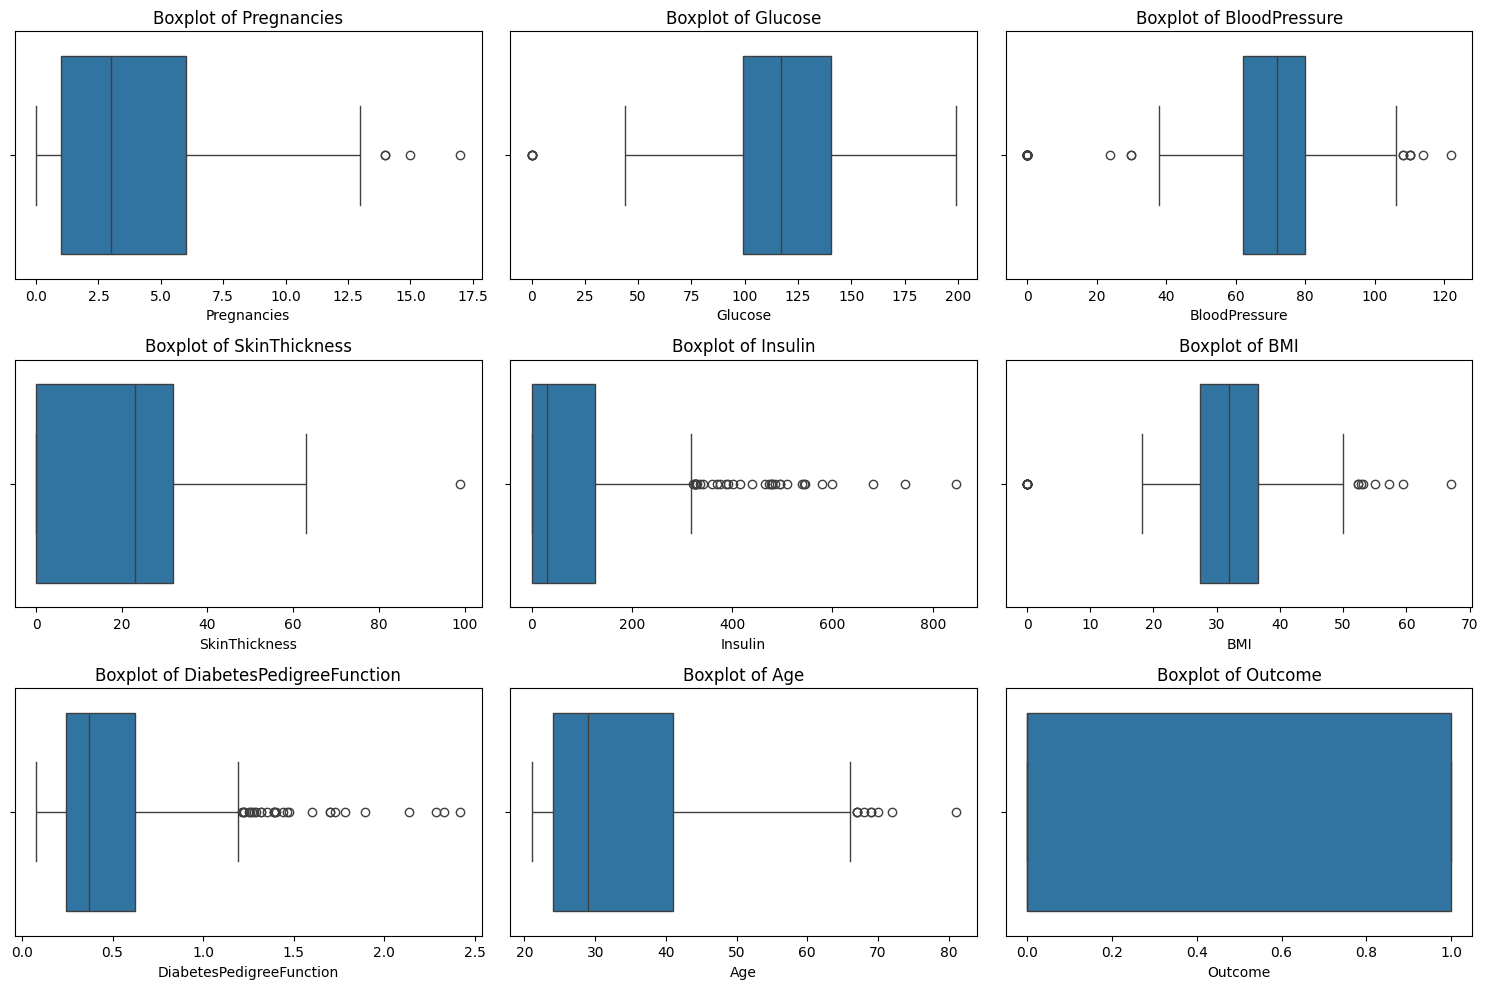

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [ ]:
zero_counts = (df == 0).sum()


columns_with_zeros = zero_counts[zero_counts > 0]
print("Columns with counts of 0:")
print(columns_with_zeros)


total_zeros_per_column = zero_counts[zero_counts > 0].sum()
print("\nTotal count of zeros for each column:")
print(total_zeros_per_column)

Columns with counts of 0:
Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64

Total count of zeros for each column:
1263


In [ ]:
# KNN IMPUTATION
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)


imputer = KNNImputer(n_neighbors=5)


df[columns_with_zeros] = imputer.fit_transform(df[columns_with_zeros])

print("Count of 0 values after imputation:")
print(df[columns_with_zeros].eq(0).sum())

Count of 0 values after imputation:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [ ]:
def handle_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column])
    outliers = (z_scores > threshold) | (z_scores < -threshold)

    # Replace outliers with the median
    data.loc[outliers, column] = data[column].median()
    return data


numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
for column in numerical_columns:
    df = handle_outliers_zscore(df, column)

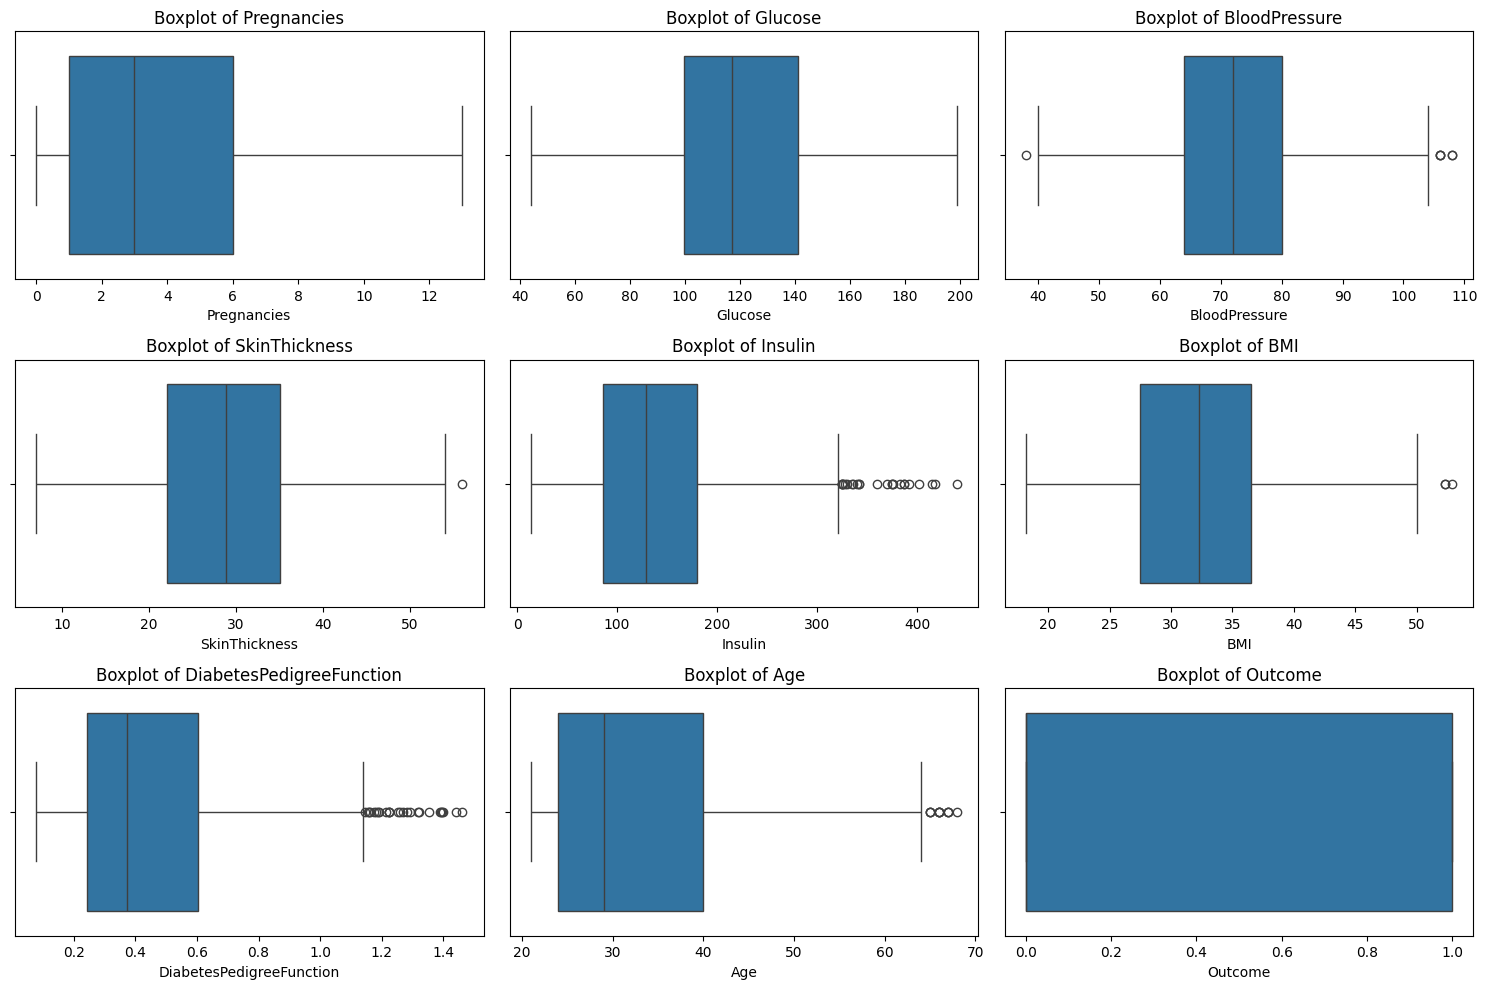

In [ ]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

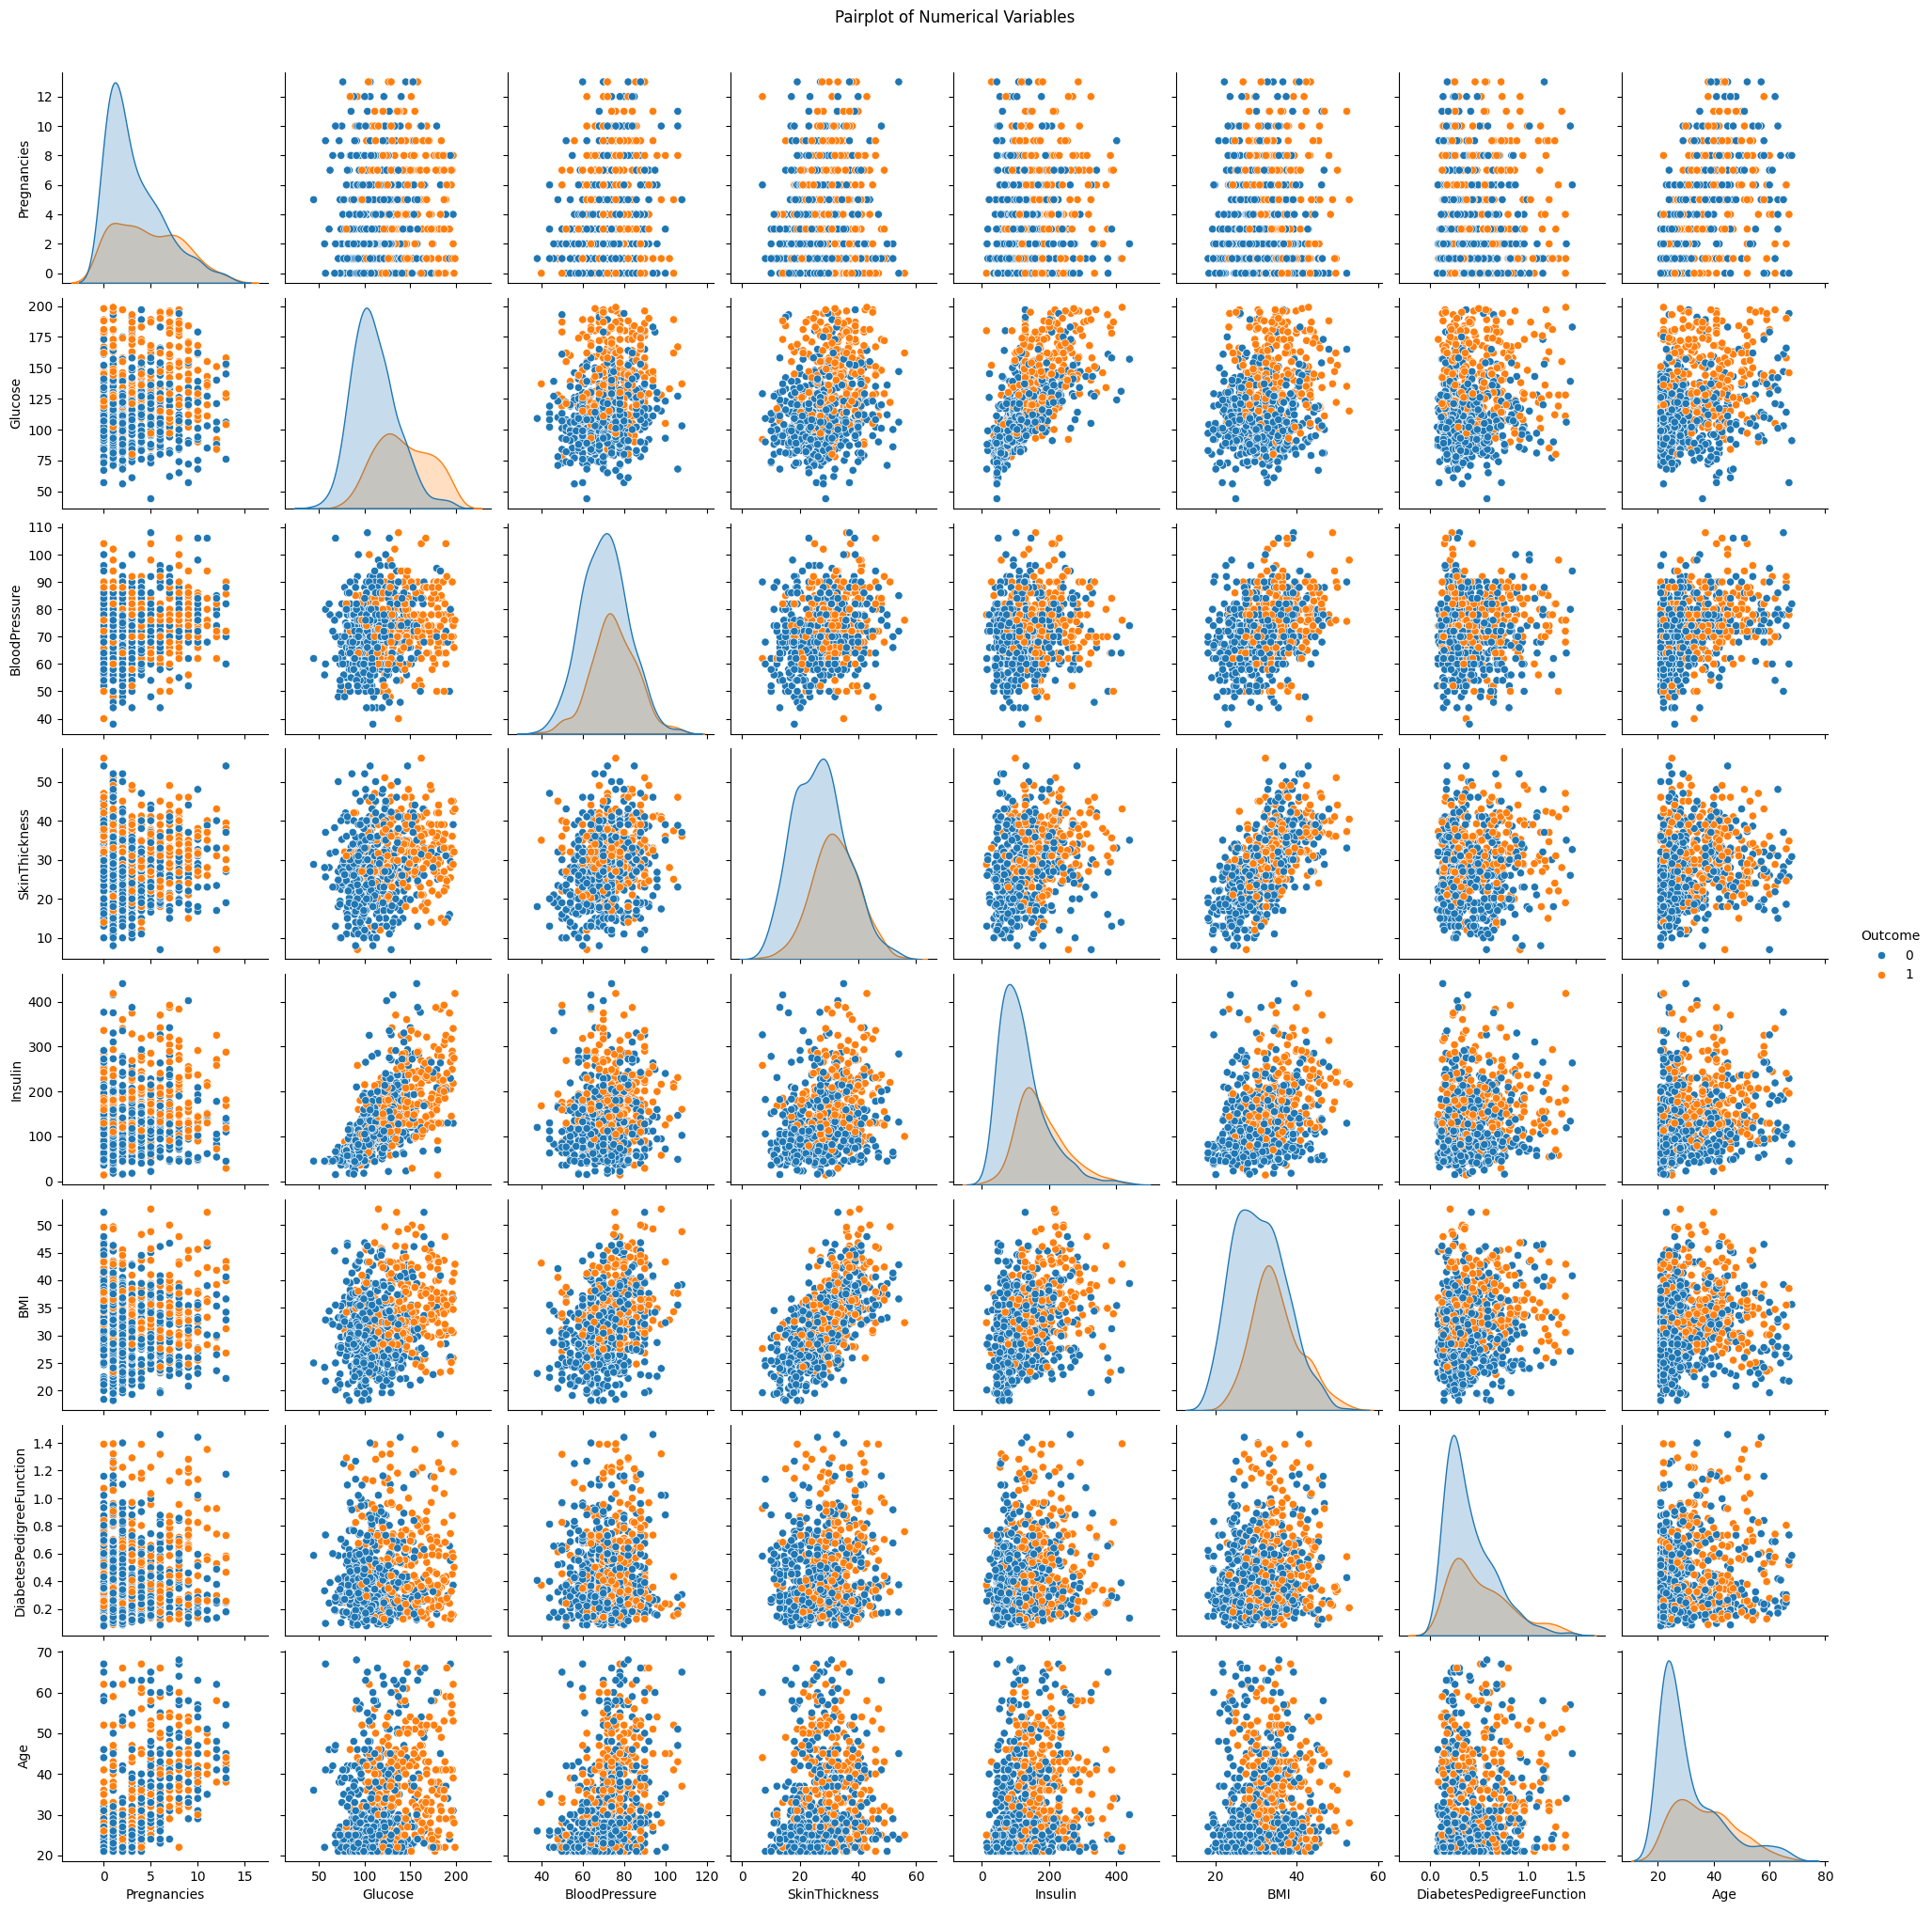

In [ ]:
plt.figure(figsize=(12, 10))

sns.pairplot(df, hue='Outcome', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

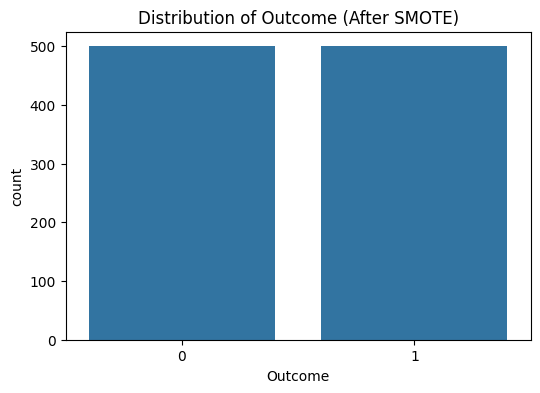

In [ ]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Outcome')], axis=1)


plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df_resampled)
plt.title('Distribution of Outcome (After SMOTE)')
plt.show()

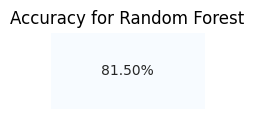

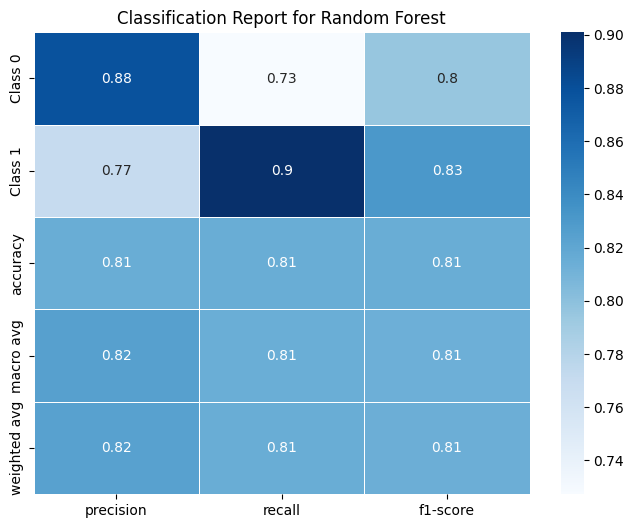

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)

rf_report = classification_report(y_test, rf_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[rf_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Random Forest')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(rf_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Random Forest')
plt.show()

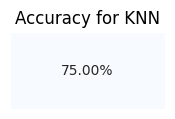

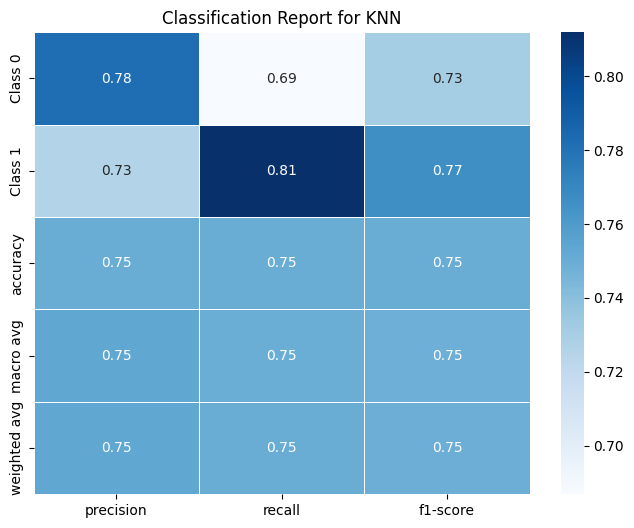

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)


knn_accuracy = accuracy_score(y_test, knn_pred)


knn_report = classification_report(y_test, knn_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[knn_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for KNN')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(knn_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for KNN')
plt.show()

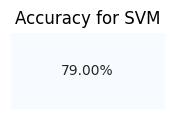

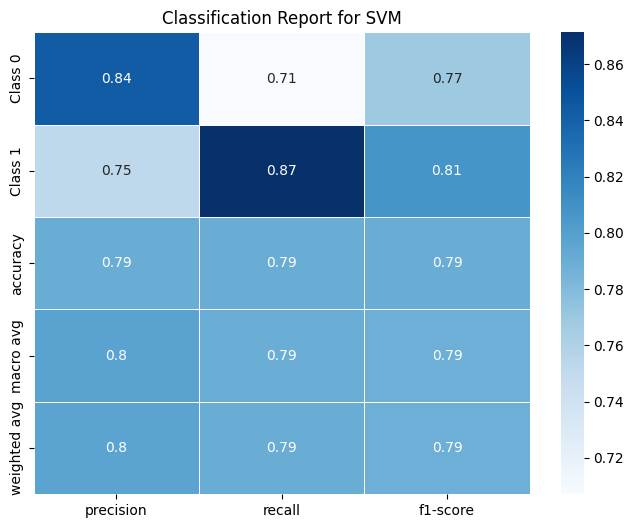

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

svm_accuracy = accuracy_score(y_test, svm_pred)


svm_report = classification_report(y_test, svm_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[svm_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for SVM')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(svm_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for SVM')
plt.show()

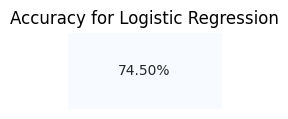

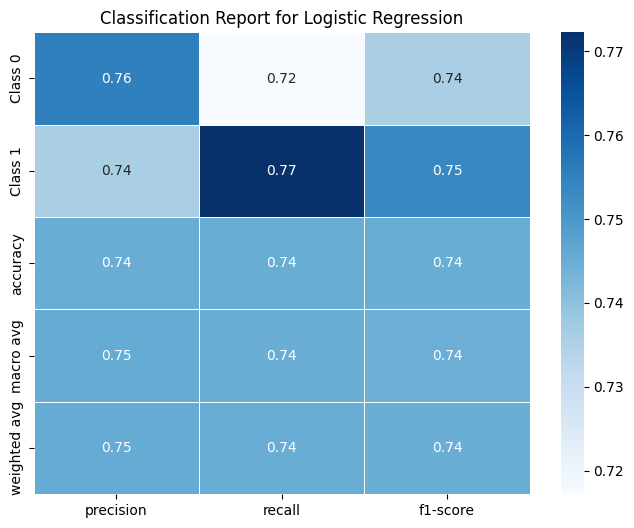

In [ ]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)
logreg_pred = logreg_model.predict(X_test_scaled)


logreg_accuracy = accuracy_score(y_test, logreg_pred)


logreg_report = classification_report(y_test, logreg_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[logreg_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Logistic Regression')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(logreg_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Logistic Regression')
plt.show()

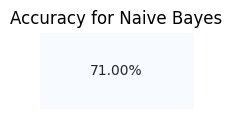

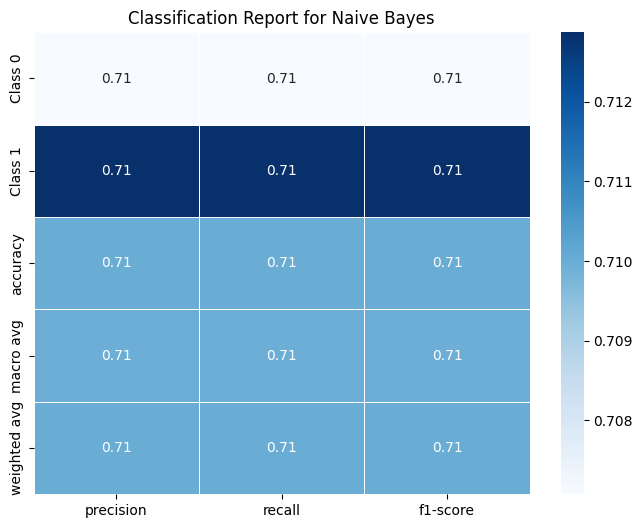

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_pred = nb_model.predict(X_test_scaled)


nb_accuracy = accuracy_score(y_test, nb_pred)


nb_report = classification_report(y_test, nb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[nb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Naive Bayes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(nb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Naive Bayes')
plt.show()

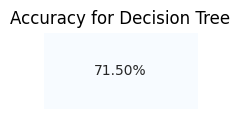

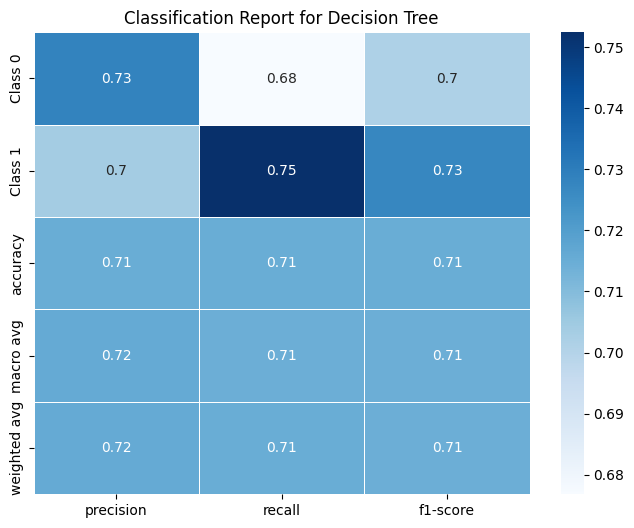

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)


dt_accuracy = accuracy_score(y_test, dt_pred)


dt_report = classification_report(y_test, dt_pred, target_names=['Class 0', 'Class 1'], output_dict=True)


plt.figure(figsize=(2, 1))
sns.heatmap([[dt_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Decision Tree')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(dt_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Decision Tree')
plt.show()

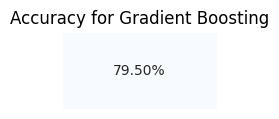

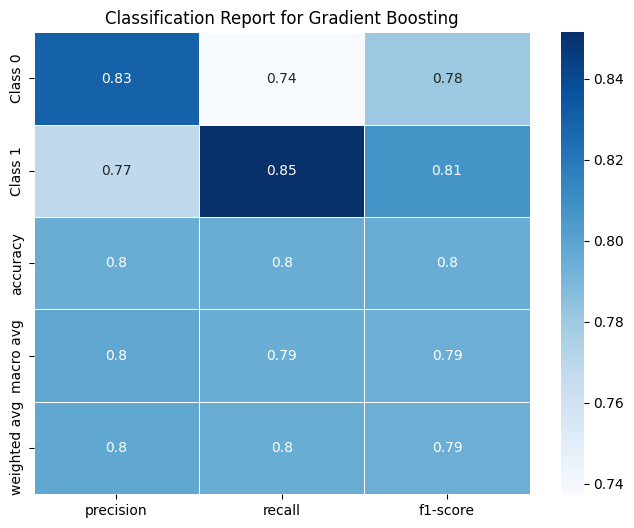

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)


gb_accuracy = accuracy_score(y_test, gb_pred)


gb_report = classification_report(y_test, gb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)


plt.figure(figsize=(2, 1))
sns.heatmap([[gb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Gradient Boosting')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(gb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Gradient Boosting')
plt.show()

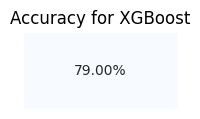

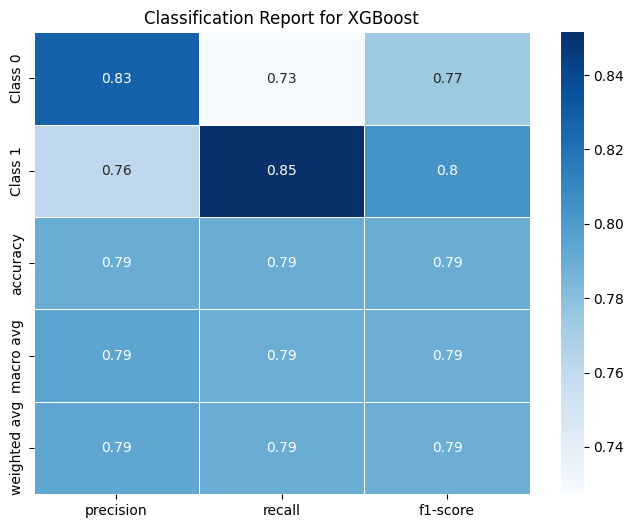

In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)


xgb_accuracy = accuracy_score(y_test, xgb_pred)

xgb_report = classification_report(y_test, xgb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[xgb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for XGBoost')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(xgb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for XGBoost')
plt.show()

In [ ]:
rf_accuracy = 81.00
knn_accuracy = 75.00
svm_accuracy = 79.00
logreg_accuracy = 74.50
nb_accuracy = 71.00
dt_accuracy = 71.50
gb_accuracy = 79.50
xgb_accuracy = 79.00

accuracy_dict = {
    'Random Forest': rf_accuracy,
    'k-Nearest Neighbors': knn_accuracy,
    'Support Vector Machine': svm_accuracy,
    'Logistic Regression': logreg_accuracy,
    'Naive Bayes': nb_accuracy,
    'Decision Tree': dt_accuracy,
    'Gradient Boosting': gb_accuracy,
    'XGBoost': xgb_accuracy
}
max_accuracy_var = max(accuracy_dict, key=accuracy_dict.get)
max_accuracy = accuracy_dict[max_accuracy_var]
print("Greatest Accuracy:", max_accuracy_var, max_accuracy)

Greatest Accuracy: Random Forest 81.0


In [ ]:
# Assuming you have imported and trained the Random Forest model and stored it in rf_model

import numpy as np

# Convert the input data into a suitable format for prediction
input_data = np.array([59, 1, 1, 1, 2, 1, 2, 1]).reshape(1, -1)  # Reshape to a 2D array with one row

# Make predictions
prediction = rf_model.predict(input_data)

# Output the prediction
if prediction[0] == 1:
    print("The person is predicted to have the disease.")
else:
    print("The person is predicted to be healthy.")


The person is predicted to be healthy.


In [ ]:
import numpy as np
input_data = np.array([59, 1, 1, 1, 2, 1, 2, 1]).reshape(1, -1)
prediction = rf_model.predict(input_data)
if prediction[0] == 0:
    print("The person is predicted to have the disease.")
else:
    print("The person is predicted to be healthy.")

The person is predicted to have the disease.
